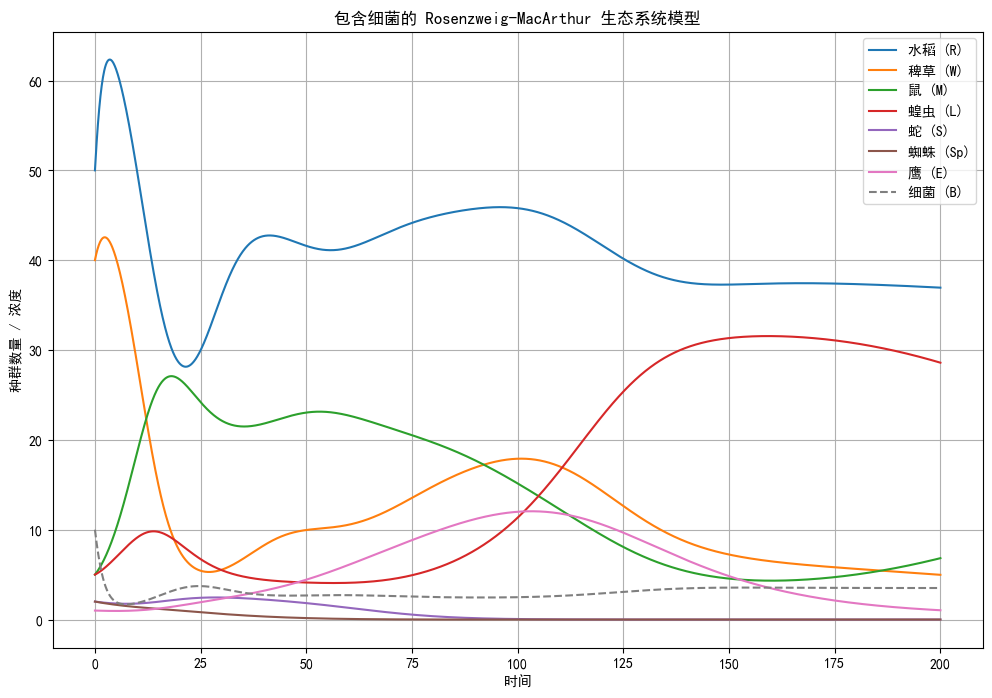

In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

def rosenzweig_macarthur_with_bacteria(y, t, params):
    """
    建立一个包含 8 个物种的 Rosenzweig-MacArthur 型模型:
      1)  R(t):  水稻 (生产者)
      2)  W(t):  稗草 (生产者)
      3)  M(t):  鼠 (初级捕食者)         - 吃水稻 R、稗草 W
      4)  L(t):  蝗虫 (初级捕食者)       - 吃水稻 R、稗草 W
      5)  S(t):  蛇 (次级捕食者)         - 吃鼠 M、蝗虫 L
      6)  Sp(t): 蜘蛛 (次级捕食者)       - 吃蝗虫 L
      7)  E(t):  鹰 (顶级捕食者)         - 吃蛇 S、蜘蛛 Sp、鼠 M
      8)  B(t):  细菌 (分解者)           - 利用各物种的死亡，作为自然资源被水稻 R 和稗草 W 消耗

    说明:
    - 细菌 B(t) 的增长来自于所有其他物种的死亡率与种群数量的乘积之和，再乘以系数 alphaB。
    - 水稻 R 和稗草 W 消耗细菌 B 来促进其生长。
    - 鼠 M 和蝗虫 L 不再消费细菌 B。
    - 其余捕食关系保持不变。
    """

    # 解包状态变量
    R, W, M, L, S, Sp, E, B = y

    # 解包参数
    (
        # 生产者参数 (水稻 R, 稗草 W)
        rR, KR,   # 水稻 R 的增长率、环境容量
        rW, KW,   # 稗草 W 的增长率、环境容量

        # 鼠 M 对 (R, W) 的捕食系数与效率
        aRM, bRM, eMR,   # M 吃 R
        aWM, bWM, eMW,   # M 吃 W

        # 蝗虫 L 对 (R, W) 的捕食系数与效率
        aRL, bRL, eLR,   # L 吃 R
        aWL, bWL, eLW,   # L 吃 W

        # 蛇 S 对 (M, L) 的捕食系数与效率
        aSM, bSM, eSM,    # S 吃 M
        aSL, bSL, eSL,    # S 吃 L

        # 蜘蛛 Sp 对 (L) 的捕食系数与效率
        aSpL, bSpL, eSpL,  # Sp 吃 L

        # 鹰 E 对 (S, Sp, M) 的捕食系数与效率
        aES, bES, eES,     # E 吃 S
        aESp, bESp, eESp,  # E 吃 Sp
        aEM, bEM, eEM,     # E 吃 M

        # 水稻 R 和 稗草 W 消耗细菌 B 的参数
        aBR, bBR, eRB,     # R 吃 B
        aBW, bBW, eWB,     # W 吃 B

        # 细菌 B 分解系数
        alphaB,

        # 各物种死亡率 (dR, dW, dM, dL, dS, dSp, dE, dB)
        dR, dW, dM, dL, dS, dSp, dE, dB
    ) = params

    # ------------------------------------------------------
    # 1. 生产者 R(t) 和 W(t) (水稻和稗草)
    #    Logistic 增长 + 消耗细菌 B 促进生长 - 被 M 和 L 消耗 - 自然死亡
    # ------------------------------------------------------
    # 鼠对水稻 R 的消耗
    cons_R_by_M = (aRM * R * M) / (1.0 + bRM * R)
    # 蝗虫对水稻 R 的消耗
    cons_R_by_L = (aRL * R * L) / (1.0 + bRL * R)
    # 水稻 R 消耗细菌 B
    cons_B_by_R = (aBR * B * R) / (1.0 + bBR * B)
    # 水稻 R 从消费 B 中获得的增长
    gain_R_from_B = eRB * cons_B_by_R

    dRdt = rR * R * (1 - R / KR) + gain_R_from_B - cons_R_by_M - cons_R_by_L - dR * R

    # 稗草 W(t) - 类似处理
    cons_W_by_M = (aWM * W * M) / (1.0 + bWM * W)
    cons_W_by_L = (aWL * W * L) / (1.0 + bWL * W)
    cons_B_by_W = (aBW * B * W) / (1.0 + bBW * B)
    gain_W_from_B = eWB * cons_B_by_W

    dWdt = rW * W * (1 - W / KW) + gain_W_from_B - cons_W_by_M - cons_W_by_L - dW * W

    # ------------------------------------------------------
    # 2. 初级捕食者 M(t) 和 L(t) (鼠和蝗虫)
    #    进食生产者 R 和 W -> 增长 - 被更高营养级捕食 - 自然死亡
    # ------------------------------------------------------
    # 鼠 M(t)
    gain_M_from_R = eMR * cons_R_by_M
    gain_M_from_W = eMW * cons_W_by_M

    # 鼠被蛇 S 和鹰 E 捕食
    cons_M_by_S = (aSM * M * S) / (1.0 + bSM * M)
    cons_M_by_E = (aEM * M * E) / (1.0 + bEM * M)

    dMdt = gain_M_from_R + gain_M_from_W - cons_M_by_S - cons_M_by_E - dM * M

    # 蝗虫 L(t)
    gain_L_from_R = eLR * cons_R_by_L
    gain_L_from_W = eLW * cons_W_by_L

    # 蝗虫被蛇 S 和蜘蛛 Sp 捕食
    cons_L_by_S = (aSL * L * S) / (1.0 + bSL * L)
    cons_L_by_Sp = (aSpL * L * Sp) / (1.0 + bSpL * L)

    dLdt = gain_L_from_R + gain_L_from_W - cons_L_by_S - cons_L_by_Sp - dL * L

    # ------------------------------------------------------
    # 3. 次级捕食者 S(t) 和 Sp(t) (蛇和蜘蛛)
    #    进食初级捕食者 -> 增长 - 被鹰捕食 - 自然死亡
    # ------------------------------------------------------
    # 蛇 S(t)
    gain_S_from_M = eSM * cons_M_by_S
    gain_S_from_L = eSL * cons_L_by_S

    # 蛇被鹰 E 捕食
    cons_S_by_E = (aES * S * E) / (1.0 + bES * S)

    dSdt = gain_S_from_M + gain_S_from_L - cons_S_by_E - dS * S

    # 蜘蛛 Sp(t)
    gain_Sp_from_L = eSpL * cons_L_by_Sp

    # 蜘蛛被鹰 E 捕食
    cons_Sp_by_E = (aESp * Sp * E) / (1.0 + bESp * Sp)

    dSpdt = gain_Sp_from_L - cons_Sp_by_E - dSp * Sp

    # ------------------------------------------------------
    # 4. 顶级捕食者 E(t) (鹰)
    #    进食 S, Sp, M -> 增长 - 自然死亡
    # ------------------------------------------------------
    gain_E_from_S = eES * cons_S_by_E
    gain_E_from_Sp = eESp * cons_Sp_by_E
    gain_E_from_M = eEM * cons_M_by_E

    dEdt = gain_E_from_S + gain_E_from_Sp + gain_E_from_M - dE * E

    # ------------------------------------------------------
    # 5. 细菌 B(t) (分解者)
    #    由各物种的死亡贡献增长 - 被 R 和 W 消耗 - 自然死亡
    # ------------------------------------------------------
    # 细菌增长
    total_death_flux = (dR * R + dW * W + dM * M + dL * L + dS * S + dSp * Sp + dE * E)
    bacteria_growth = alphaB * total_death_flux

    # 细菌被生产者消耗
    cons_B_consumed_by_R = cons_B_by_R  # 已在 R 的算式中计算
    cons_B_consumed_by_W = cons_B_by_W  # 已在 W 的算式中计算

    dBdt = bacteria_growth - cons_B_consumed_by_R - cons_B_consumed_by_W - dB * B

    return [dRdt, dWdt, dMdt, dLdt, dSdt, dSpdt, dEdt, dBdt]

# ---------------------------
# 示例参数 (仅用于演示, 请根据实际需要进行调整)
# ---------------------------
params_example = (
    # 水稻 R: logistic
    0.8, 80.0,    # rR, KR
    # 稗草 W: logistic
    0.6, 60.0,    # rW, KW

    # 鼠 M 消费(水稻 R, 稗草 W)
    0.02, 0.01, 0.2,    # aRM, bRM, eMR
    0.02, 0.01, 0.2,    # aWM, bWM, eMW

    # 蝗虫 L 消费(水稻 R, 稗草 W)
    0.015, 0.01, 0.2,   # aRL, bRL, eLR
    0.015, 0.01, 0.2,   # aWL, bWL, eLW

    # 蛇 S 消费(鼠 M, 蝗虫 L)
    0.01, 0.01, 0.3,    # aSM, bSM, eSM
    0.01, 0.01, 0.3,    # aSL, bSL, eSL

    # 蜘蛛 Sp 消费(蝗虫 L)
    0.01, 0.01, 0.35,   # aSpL, bSpL, eSpL

    # 鹰 E 消费(蛇 S, 蜘蛛 Sp, 鼠 M)
    0.01, 0.01, 0.4,    # aES, bES, eES
    0.01, 0.01, 0.4,    # aESp, bESp, eESp
    0.01, 0.01, 0.4,    # aEM, bEM, eEM

    # 水稻 R 消耗细菌 B
    0.005, 0.01, 0.1,   # aBR, bBR, eRB
    # 稗草 W 消耗细菌 B
    0.005, 0.01, 0.1,   # aBW, bBW, eWB

    # 细菌 B 分解系数
    0.2,                 # alphaB

    # 各物种死亡率 (dR, dW, dM, dL, dS, dSp, dE, dB)
    0.02, 0.02, 0.1, 0.1, 0.05, 0.05, 0.05, 0.05
)

# 初始值 [R, W, M, L, S, Sp, E, B]
y0 = [50, 40, 5, 5, 2, 2, 1, 10]

# 时间序列
t = np.linspace(0, 200, 2001)

# 用 odeint 求解
solution = odeint(rosenzweig_macarthur_with_bacteria, y0, t, args=(params_example,))
R_sol, W_sol, M_sol, L_sol, S_sol, Sp_sol, E_sol, B_sol = solution.T

# ---------------------------
# 绘图
#
plt.rcParams['font.family'] = 'SimHei'  # 替换为你选择的字体
plt.figure(figsize=(12, 8))
plt.plot(t, R_sol, label='水稻 (R)')
plt.plot(t, W_sol, label='稗草 (W)')
plt.plot(t, M_sol, label='鼠 (M)')
plt.plot(t, L_sol, label='蝗虫 (L)')
plt.plot(t, S_sol, label='蛇 (S)')
plt.plot(t, Sp_sol, label='蜘蛛 (Sp)')
plt.plot(t, E_sol, label='鹰 (E)')
plt.plot(t, B_sol, label='细菌 (B)', linestyle='--')
plt.xlabel('时间')
plt.ylabel('种群数量 / 浓度')
plt.title('包含细菌的 Rosenzweig-MacArthur 生态系统模型')
plt.legend()
plt.grid(True)
plt.show()